# Modelos de Regresion

Utilizando modelos de regresion, buscamos predecir la satisfaccion del cliente y los retrasos en entregas.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV

# Abrir CSV
df = pd.read_csv('./dataset/cleaned_orders.csv')
df['delivery_delayed'] =  df['delivery_delayed'].astype(int)
df['different_state'] = df['different_state'].astype(int)

# Eliminar algunas variables respuesta de otros modelos
df.drop(columns=['has_comment', 'has_title'], inplace=True)
df = df.dropna()

# Separar en test y train con 30/70 para predicciones de satisfaccion
dftrain, dftest = train_test_split(
    df,
    test_size=0.3,
    stratify=df['review_score'],
    random_state=42
)

# Separar en test y train con 30/70 para predicciones de delivery
dftrain_d, dftest_d = train_test_split(
    df,
    test_size=0.3,
    random_state=42
)

df.drop(columns=['delivery_delta', 'review_score'], inplace=True)

# Eliminar columnas que practicamente nos dan la respuesta
dftrain_d.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta','review_score'], inplace=True)
dftest_d.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dftrain_d.head(15)


,delivery_days,avg_product_price,total_order_price,item_count,order_freight_value,avg_product_weight,total_order_weight_g,avg_product_volume_cm3,total_order_volume_cm3,freight_to_price,...,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
48973,16,44.90,44.90,1,15.11,900.0,900.0,13440.0,13440.0,0.336526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17686,22,689.89,689.89,1,21.67,1500.0,1500.0,9075.0,9075.0,0.031411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
35797,6,37.99,37.99,1,11.85,1800.0,1800.0,9180.0,9180.0,0.311924,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
51599,6,135.00,135.00,1,14.70,500.0,500.0,1056.0,1056.0,0.108889,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
13447,10,89.90,89.90,1,17.20,1400.0,1400.0,8000.0,8000.0,0.191324,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
87458,7,6.90,20.70,3,14.52,100.0,300.0,704.0,2112.0,0.701449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45288,15,125.00,250.00,2,14.22,125.0,250.0,2304.0,4608.0,0.056880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12912,8,110.90,110.90,1,15.54,1500.0,1500.0,16928.0,16928.0,0.140126,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
84024,14,213.00,213.00,1,24.07,1000.0,1000.0,7500.0,7500.0,0.113005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51872,9,949.99,949.99,1,21.97,4700.0,4700.0,36000.0,36000.0,0.023127,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Regresion Lineal

### Prediccion Satisfaccion Cliente

Primero, separamos los modelos entre X e Y con la variable objetivo

In [3]:
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
y_test = dftest['review_score']

Empezando, vamos a realizar una regresion simple con todas las variables

R² Score: 0.178
MSE: 1.36


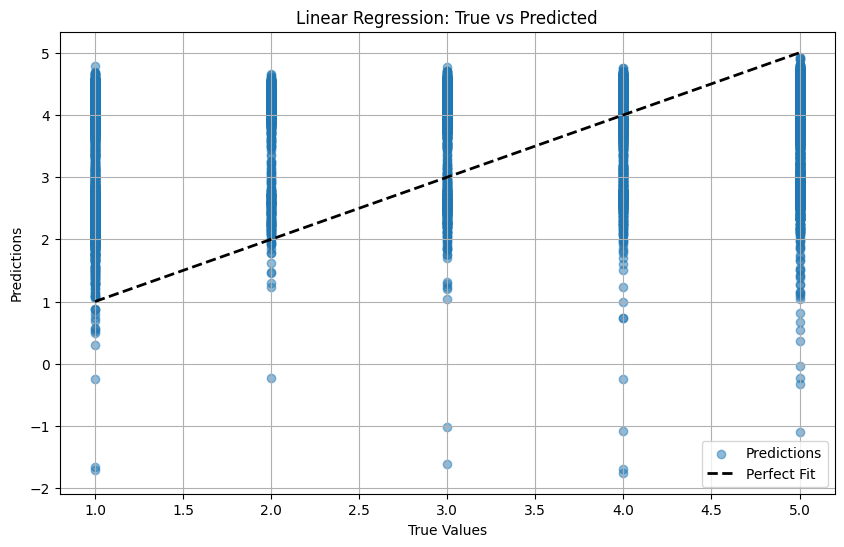

In [4]:
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

Al tener algunas variables correlacionadas, debemos depurar las variables que incluimos dentro del modelo

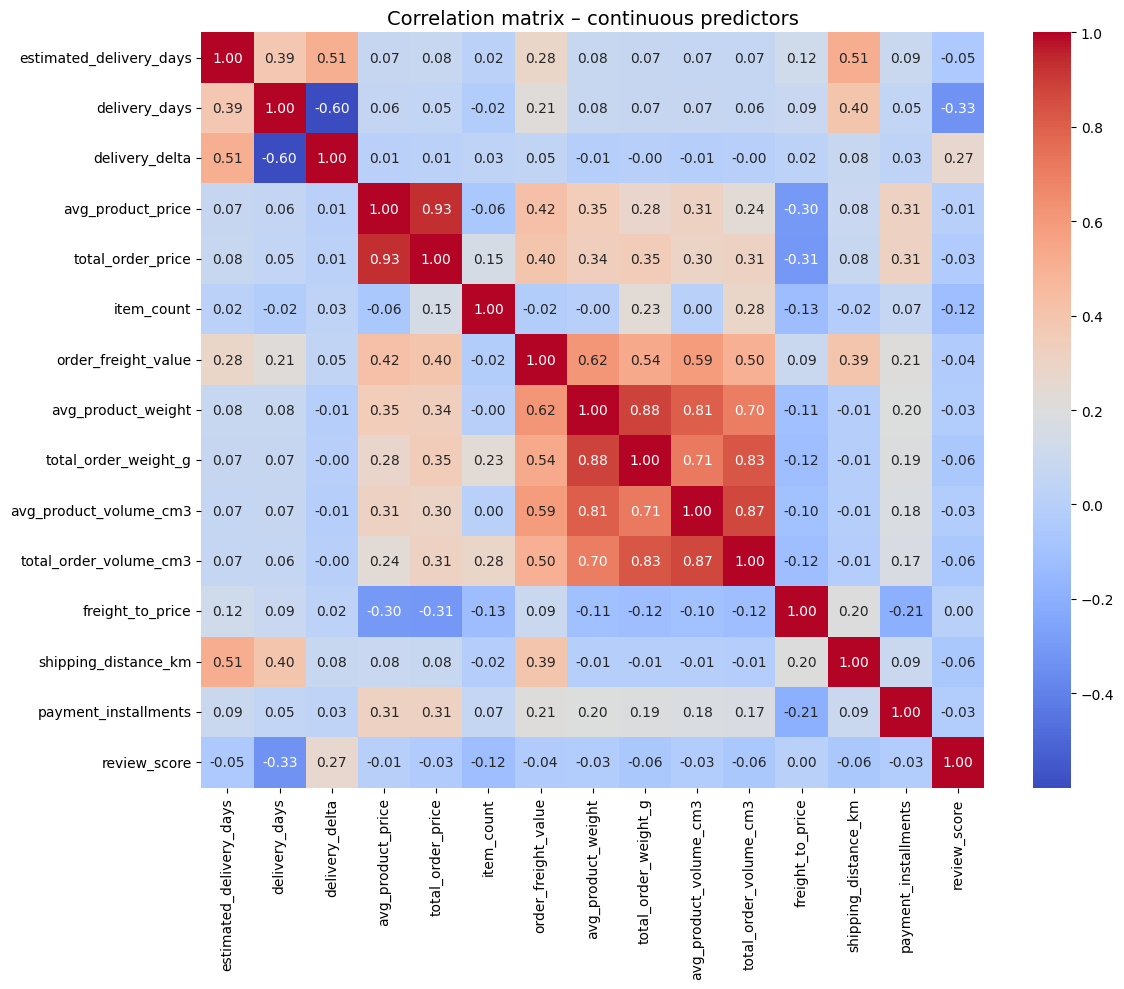

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns


cont_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if (df[c].nunique() >= 3) and c != 'review_score'
]

df_cont = df[cont_cols + ['review_score']].dropna()

corr = df_cont.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()

En la matriz de correlación anterior podemos observar que hay algunas variables que tienen correlación con review_score. Pero también podemos ver que hay regresores que tienen alta colinealidad entre ellos. Esto sugiere que el modelo debe ser depurado

In [7]:
X = df_cont.drop(columns=['review_score'])
y = df_cont['review_score']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)


def backward_elimination(X, y, sl=0.05):
    feats = X.columns.tolist()
    while True:
        model = sm.OLS(y, sm.add_constant(X[feats])).fit()
        pvals = model.pvalues.drop('const')
        worst_p = pvals.max()
        if worst_p > sl:
            feats.remove(pvals.idxmax())
        else:
            return model, feats

be_model, sel_feats = backward_elimination(X_train, y_train)

print("\n=== Resumen del modelo depurado (sin dummies) ===\n")
print(be_model.summary())
print(f"\nVariables seleccionadas: {sel_feats}")

usecols = sel_feats + ['review_score']
clear_df = pd.read_csv('/dataset/cleaned_orders.csv', usecols=usecols)


=== Resumen del modelo depurado (sin dummies) ===

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1339.
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        03:04:16   Log-Likelihood:            -1.2068e+05
No. Observations:               75622   AIC:                         2.414e+05
Df Residuals:                   75612   BIC:                         2.415e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

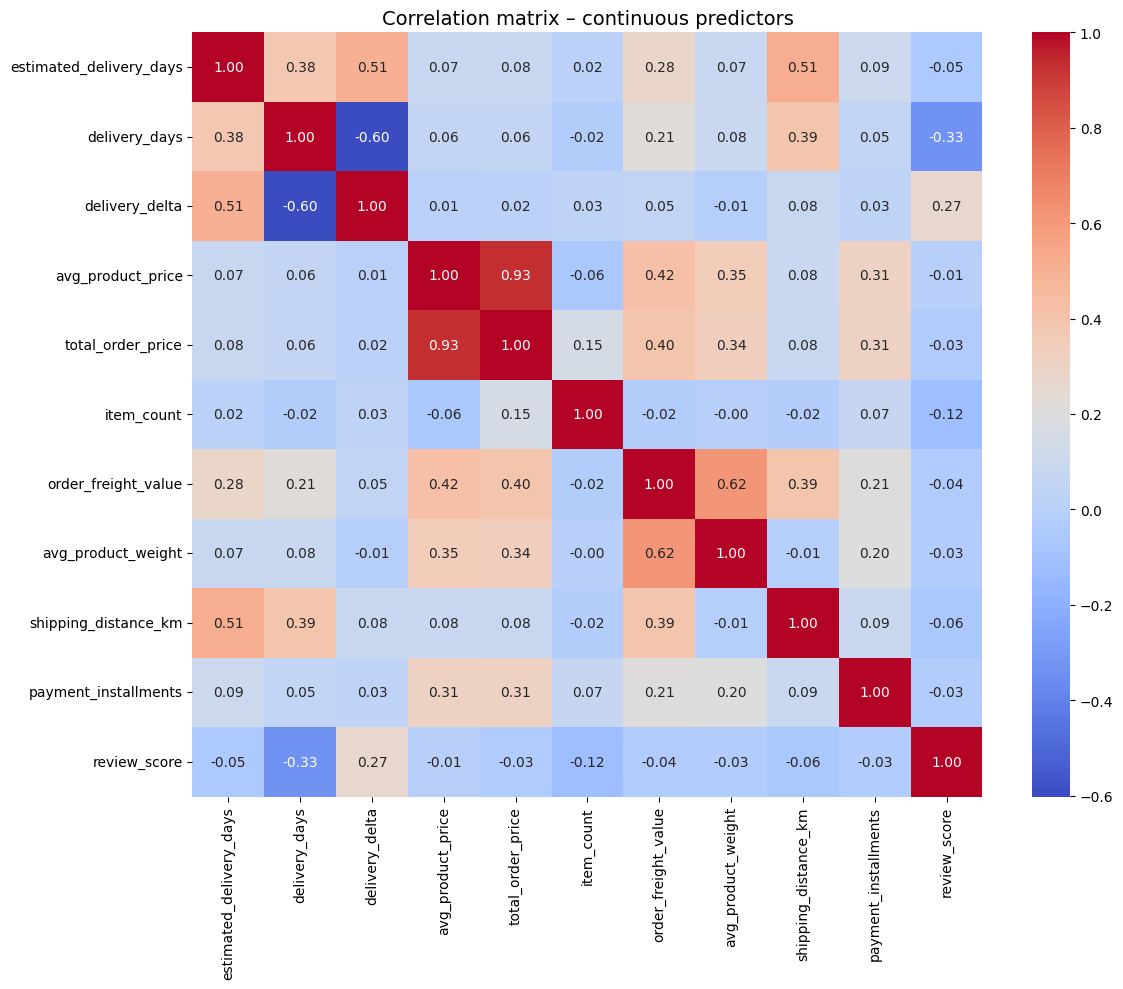

In [8]:
corr = clear_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()

Luego de depurar el modelo, podemos observar que se conservaron las clumnas estimated_delvery_days, delivery_days, delivery_delta, avg_product_price, total_order_price, item_count, order_freight_value, avg_product_weight, shipping_distance_km y payment_installments


RMSE hold‑out: 1.1827
R² hold‑out: 0.1433


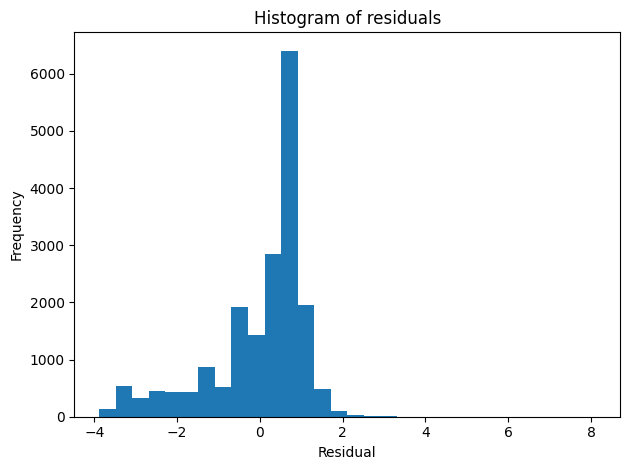

<Figure size 640x480 with 0 Axes>

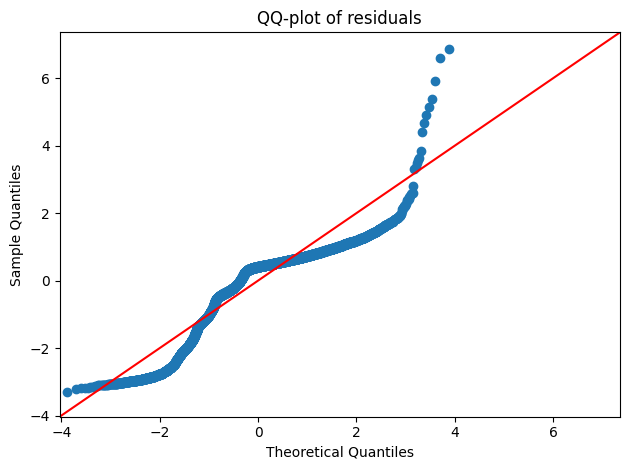

In [9]:
linreg = LinearRegression().fit(X_train[sel_feats], y_train)
y_pred = linreg.predict(X_test[sel_feats])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'\nRMSE hold‑out: {rmse:.4f}')
print(f'R² hold‑out: {r2:.4f}')

residuals = y_test - y_pred

# Histograma de residuales
plt.figure()
plt.hist(residuals, bins=30)
plt.title('Histogram of residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# QQ‑plot
plt.figure()
qqplot(residuals, line='45', fit=True)
plt.title('QQ‑plot of residuals')
plt.tight_layout()
plt.show()

Los errores están centrados en 0 (modelo no sesgado en promedio) pero la distribución es asimétrica y con colas gruesas (kurtosis > 0).

Las colas de la distribución empírica son más pesadas que las de una normal; se confirma la falta de normalidad.

In [10]:
params = be_model.params
intercept = params['const']
betas = params.drop('const')


eq = f"ŷ = {intercept:.4f}"
for var, coef in betas.items():
    sign = "+" if coef >= 0 else "-"
    eq += f" {sign} {abs(coef):.4f}·{var}"

print("Ecuación del modelo lineal:")
print(eq)

Ecuación del modelo lineal:
ŷ = 4.8121 - 0.0107·estimated_delivery_days - 0.0315·delivery_days + 0.0208·delivery_delta + 0.0003·avg_product_price - 0.0003·total_order_price - 0.2860·item_count + 0.0010·order_freight_value - 0.0000·avg_product_weight + 0.0001·shipping_distance_km - 0.0058·payment_installments


En la parte de arriba podemos observar la ecuación del modelo ya depurado el cual nos maximiza el R² a un 0.137 y un adj-R² de 0.137 de igual forma

##

## Random Forest

Para implementar este modelo de regresion, primero vamos a elegir algunos valores iniciales para cada una de las regresiones que vamos a realizar. Luego, vamos a interpretar estos valores iniciales para intentar explicar ciertos comportamientos y predecir la influencia de valores mas optimos. Por ultimo, vamos a utilizar GridSearch para encontrar los valores optimos y analizar el rendimiento de este modelo optimizado

### Satisfaccion del Cliente

Importamos el regresor de random forest, creamos los splits X e Y tanto para prueba como para entrenamiento y entrenamos nuestro modelo inicial.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Separacion X / Y train
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

# Separacion X / Y test
x_test = dftest.drop(columns=['review_score'])
y_train = dftrain['review_score']

# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento de modelo
rf_regressor.fit(x_train, y_train)

# Predicciones con el modelo
y_pred = rf_regressor.predict(x_test)

# Estadisticas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir estadisticas
print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [18906, 28359]

Podemos observar que el modelo no parece ser muy preciso, tiene un R2 de 0.18 y dentro de la grafica podemos ver que el trendline parece seguir un patron completamente diferente. Ademas, el modelo nunca predijo un review_score menor a 1.5, esto nos puede indicar que la distribucion que sigue la variable respuesta puede tener una distribucion con muy pocos valores bajos. A continuacion, vamos a realizar un Gridsearch para intentar tener un modelo con un mejor rendimiento.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters:", grid_search.best_params_)
print("\nEvaluación del Modelo Random Forest Optimizado:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=15)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - Random Forest Optimizado")
plt.show()

KeyboardInterrupt: 

Al observar el rendimiento de este modelo, nos damos cuenta que los valores iniciales utilizados fueron bastante precisos. Al realizar el gridsearch con diferentes valores de profundidad, nos damos cuenta que nuestra hipotesis anterior sobre el modelo necesitando mas detalle era incorrecta. En este caso, el modelo mas efectivo encontrado resulto siendo en max_depth = 10, el valor inferior establecido. Observando nuevamente el modelo, podemos concluir que el 'problema' se encuentra con la distribucion de la variable objetivo. Ya que la mayoria de reviews se encuentra alrededor de 4 o 5 puntos el modelo suele predecirlas de manera mas precisa. Esto tambien lleva a que haga 'overshoot' con las variables inferiores. Donde en la grafica podemos observar un valor predecido de 3-5 para valores reales de 2 por ejemplo.

In [ ]:
feature_importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("10 Features mas importantes:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('10 Features mas Importantes')
plt.gca().invert_yaxis()
plt.show()

NameError: name 'best_rf' is not defined

En cuanto a los features mas importantes, el modelo nos indica que entre los factores mas importantes relacionados a la experiencia del cliente se encuentra del 'delivery_delta'. Esta variable nos indica que tantos dias luego (o antes) de la fecha de entrega estimada fue entregado el pedido.

### Delivery Days

Importamos el regresor de random forest, creamos los splits X e Y tanto para prueba como para entrenamiento y entrenamos nuestro modelo inicial.

Evaluación del Modelo Random Forest:
Mean Squared Error (MSE): 70.416421
Mean Absolute Error (MAE): 5.357163
R-squared (R²): 0.211562


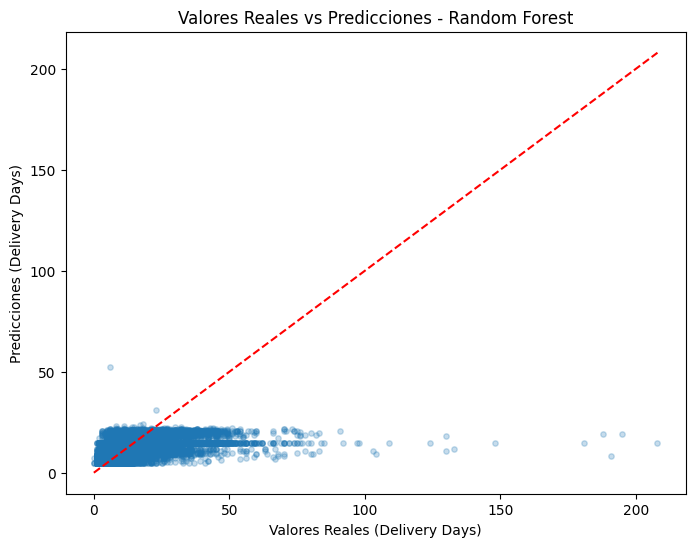

In [ ]:
# Separacion X / Y train
x_train = dftrain_d.drop(columns=['delivery_days'])
y_train = dftrain_d['delivery_days']

# Separacion X / Y test
x_test = dftest_d.drop(columns=['delivery_days'])
y_test = dftest_d['delivery_days']

# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento del modelo
rf_regressor.fit(x_train, y_train)

# Predicciones con el modelo
y_pred = rf_regressor.predict(x_test)

# Estadisticas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

#Plot de resultados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=15)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

Este modelo parece tener un rendimiento bastante pobre, segun la grafica el modelo falla en predecir correctamente valores mas altos. Esto se debe en parte a que son valores atipicos, como lo puede ser un delivery de 200+ dias. Sin embargo, observamos que no logra captar correctamente en trend desde un principio y parece mas que todo seguir una linea horizontal. Posiblemente con un parametro de profundidad mas alto se obtengan mejores resultados.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters:", grid_search.best_params_)
print("\nEvaluación del Modelo Random Forest Optimizado:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='red', linestyle='--')
plt.xlabel("Valores Reales (SalePrice)")
plt.ylabel("Predicciones (SalePrice)")
plt.title("Valores Reales vs Predicciones - Random Forest Optimizado")
plt.show()

KeyboardInterrupt: 

Por ultimo, podemos investigar los features mas importantes dentro de este modelo.

In [ ]:
feature_importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("10 Features mas importantes:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('10 Features mas Importantes')
plt.gca().invert_yaxis()
plt.show()

NameError: name 'best_rf' is not defined

## KNN

### Satisfaccion del Cliente

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


x_train = dftrain.drop(columns=['review_score'])
x_train = scaler.fit_transform(x_train)

y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
x_test = scaler.fit_transform(x_test)
y_test = dftest['review_score']

In [14]:
from sklearn.neighbors import KNeighborsRegressor

# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(x_train, y_train)

# Predicciones
y_pred_knn = knn_model.predict(x_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

Resultados KNN Regression:
MAE  = 0.92 días
RMSE = 1.26 días
R²   = 0.0412


In [ ]:
param_grid = {
    'n_neighbors': [9, 11, 13, 15, 17],
    'p': [1,2]
}

 # Create the KNN Regressor
knn = KNeighborsRegressor()


 # Create the GridSearchCV object
grid_search = GridSearchCV(
  knn, param_grid, cv=5, scoring='neg_mean_absolute_error'
 )  # cv=5 means 5-fold cross-validation


 # Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)


 # Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


 # Get the best model
best_knn = grid_search.best_estimator_


 # Make predictions on the test set using the best model
y_pred_knn = best_knn.predict(x_test)


 # Evaluate the best model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)


print(f"Resultados KNN Regression (Best Model):")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

KeyboardInterrupt: 

### Delivery Days

In [ ]:
x_train = dftrain_d.drop(columns=['delivery_days'])
y_train = dftrain_d['delivery_days']

x_test = dftest_d.drop(columns=['delivery_days'])
y_test = dftest_d['delivery_days']

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(x_train, y_train)

# Predicciones
y_pred_knn = knn_model.predict(x_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

Resultados KNN Regression:
MAE  = 5.80 días
RMSE = 9.06 días
R²   = 0.0817


In [ ]:


param_grid = {
    'n_neighbors': [9, 11, 13, 15, 17],
    'p': [1,2]
}

 # Create the KNN Regressor
knn = KNeighborsRegressor()


 # Create the GridSearchCV object
grid_search = GridSearchCV(
  knn, param_grid, cv=5, scoring='neg_mean_absolute_error'
 )  # cv=5 means 5-fold cross-validation


 # Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)


 # Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


 # Get the best model
best_knn = grid_search.best_estimator_


 # Make predictions on the test set using the best model
y_pred_knn = best_knn.predict(x_test)


 # Evaluate the best model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)


print(f"Resultados KNN Regression (Best Model):")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

KeyboardInterrupt: 

## SVR

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt




X_train_rs = dftrain.drop(columns=['review_score'])
y_train_rs = dftrain['review_score']

X_test_rs  = dftest.drop(columns=['review_score'])
y_test_rs  = dftest['review_score']

# ------- pipeline + búsqueda ----------
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid_rs = {
    'svr__kernel': ['rbf'],
    'svr__C'      : [0.1, 1, 10],
    'svr__epsilon': [0.05, 0.2],
    'svr__gamma'  : ['scale', 0.01]
}

gs_rs = HalvingGridSearchCV(
    svr_pipe,
    param_grid_rs,
    factor=3,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)


Exception ignored in: <function ResourceTracker.__del__ at 0x79084ce6d080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x754da5975080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x74a531e7d080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

KeyboardInterrupt: 

In [ ]:
from joblib import parallel_backend

with parallel_backend('threading'):
    gs_rs.fit(X_train_rs, y_train_rs)

best_svr_rs = gs_rs.best_estimator_
print("Mejores hiper-parámetros (review_score):", gs_rs.best_params_)

# ------- evaluación ----------
y_pred_rs = best_svr_rs.predict(X_test_rs)
print(f"MAE  = {mean_absolute_error(y_test_rs, y_pred_rs):.3f}")
print(f"RMSE = {mean_squared_error(y_test_rs, y_pred_rs, squared=False):.3f}")
print(f"R²   = {r2_score(y_test_rs, y_pred_rs):.4f}")

plt.figure(figsize=(7,5))
plt.scatter(y_test_rs, y_pred_rs, alpha=0.3, s=15)
plt.plot([y_test_rs.min(), y_test_rs.max()],
         [y_test_rs.min(), y_test_rs.max()],
         'r--')
plt.xlabel("Review real"); plt.ylabel("Predicción")
plt.title("SVR – review_score"); plt.grid(True)
plt.show()


In [ ]:
# ------- splits ya creados ----------
X_train_dd = dftrain_d.drop(columns=['delivery_days'])
y_train_dd = dftrain_d['delivery_days']

X_test_dd  = dftest_d.drop(columns=['delivery_days'])
y_test_dd  = dftest_d['delivery_days']

# ------- pipeline + búsqueda ----------
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid_dd = {
    'svr__kernel': ['rbf'],
    'svr__C'      : [0.1, 1, 10],
    'svr__epsilon': [0.05, 0.2],
    'svr__gamma'  : ['scale', 0.01]
}

gs_dd = HalvingGridSearchCV(
    svr_pipe,
    param_grid_dd,
    factor=3,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)



In [ ]:
from joblib import parallel_backend

with parallel_backend('threading'):
    gs_dd.fit(X_train_dd, y_train_dd)

best_svr_dd = gs_dd.best_estimator_
print("Mejores hiper-parámetros (delivery_days):", gs_dd.best_params_)

# ------- evaluación ----------
y_pred_dd = best_svr_dd.predict(X_test_dd)
print(f"MAE  = {mean_absolute_error(y_test_dd, y_pred_dd):.2f} días")
print(f"RMSE = {mean_squared_error(y_test_dd, y_pred_dd, squared=False):.2f} días")
print(f"R²   = {r2_score(y_test_dd, y_pred_dd):.4f}")

plt.figure(figsize=(7,5))
plt.scatter(y_test_dd, y_pred_dd, alpha=0.3, s=15)
plt.plot([y_test_dd.min(), y_test_dd.max()],
         [y_test_dd.min(), y_test_dd.max()],
         'r--')
plt.xlabel("Delivery real (días)"); plt.ylabel("Predicción (días)")
plt.title("SVR – delivery_days"); plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ------- splits ya creados ----------
X_train_dd = dftrain_d.drop(columns=['delivery_days'])
y_train_dd = dftrain_d['delivery_days']

X_test_dd  = dftest_d.drop(columns=['delivery_days'])
y_test_dd  = dftest_d['delivery_days']

# Pipeline
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Cuadrícula reducida
param_dist_dd = {
    'svr__kernel': ['rbf'],
    'svr__C': loguniform(0.1, 10),
    'svr__epsilon': uniform(0.05, 0.15),
    'svr__gamma': ['scale']
}

# RandomizedSearchCV
rs_dd = RandomizedSearchCV(
    svr_pipe,
    param_dist_dd,
    n_iter=8,  # Menos iteraciones
    cv=2,      # Menos folds
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Entrenamiento
rs_dd.fit(X_train_dd, y_train_dd)
best_svr_dd = rs_dd.best_estimator_
print("Mejores hiper-parámetros:", rs_dd.best_params_)

# Evaluación
y_pred_dd = best_svr_dd.predict(X_test_dd)
print(f"MAE  = {mean_absolute_error(y_test_dd, y_pred_dd):.2f} días")
print(f"RMSE = {mean_squared_error(y_test_dd, y_pred_dd, squared=False):.2f} días")
print(f"R²   = {r2_score(y_test_dd, y_pred_dd):.4f}")

# Gráfico
plt.figure(figsize=(7,5))
plt.scatter(y_test_dd, y_pred_dd, alpha=0.3, s=15)
plt.plot([y_test_dd.min(), y_test_dd.max()], [y_test_dd.min(), y_test_dd.max()], 'r--')
plt.xlabel("Delivery real (días)"); plt.ylabel("Predicción (días)")
plt.title("SVR – delivery_days"); plt.grid(True)
plt.show()

# Modelos de clasificación

## Regresión logística


===== Logistic Regression  →  delivery_delayed =====

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

           0      1.000     0.973     0.986     21874
           1      0.746     1.000     0.854      1758

    accuracy                          0.975     23632
   macro avg      0.873     0.986     0.920     23632
weighted avg      0.981     0.975     0.976     23632

ROC-AUC: 1.0


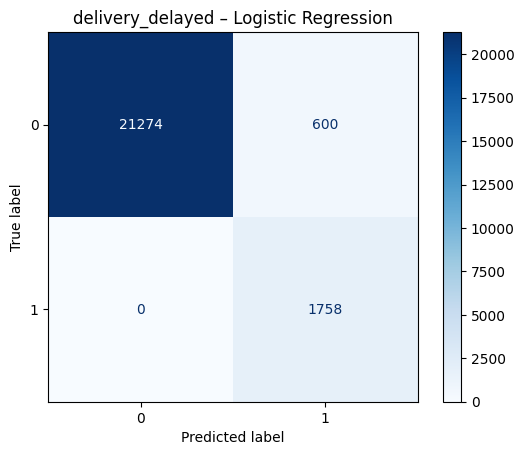


===== Logistic Regression  →  different_state =====

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

           0      0.909     0.940     0.924      8526
           1      0.965     0.947     0.956     15106

    accuracy                          0.944     23632
   macro avg      0.937     0.943     0.940     23632
weighted avg      0.945     0.944     0.944     23632

ROC-AUC: 0.986


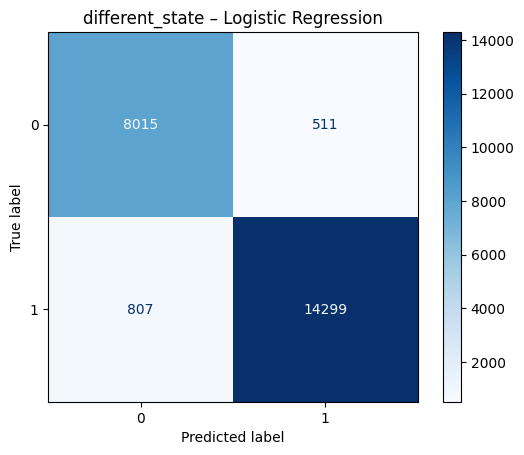

In [12]:
import os, joblib, matplotlib.pyplot as plt
import pandas as pd, numpy as np
from joblib import Memory
from scipy.stats import loguniform, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay)

TARGETS     = ["delivery_delayed", "different_state"]
RANDOM_SEED = 42
CV          = 3
memory_log  = Memory(location='./.cache_log', verbose=0)
# imputación una sola vez y cast a float32
df_filled = df.fillna(df.mean(numeric_only=True))
# Ya tienes df_filled con float32
for tgt in TARGETS:
    print(f"\n===== Logistic Regression  →  {tgt} =====\n")

    X = df_filled.drop(columns=[tgt])
    y = df_filled[tgt]

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

    # Pipeline con cache y solver saga
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            class_weight="balanced",
            max_iter=1000,
            tol=1e-3,
            n_jobs=-1,
            random_state=RANDOM_SEED))
    ], memory=memory_log)

    # RandomizedSearchCV
    GRID_DIST = {
        "clf__C": loguniform(1e-3, 1e3),
        "clf__l1_ratio": uniform(0, 1)
    }
    search = RandomizedSearchCV(
        pipe,
        param_distributions=GRID_DIST,
        n_iter=10,
        cv=CV,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=1
    )

    search.fit(Xtr, ytr)
    best = search.best_estimator_

    # Evaluación
    y_pred = best.predict(Xte)
    y_prob = best.predict_proba(Xte)[:, 1]
    cm     = confusion_matrix(yte, y_pred)

    print(classification_report(yte, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yte, y_prob).round(3))
    ConfusionMatrixDisplay(cm, display_labels=best.classes_).plot(cmap="Blues")
    plt.title(f"{tgt} – Logistic Regression")
    plt.savefig(f"cm_logreg_{tgt}.png", dpi=150, bbox_inches="tight")
    plt.show()

    joblib.dump(best, f"logreg_best_{tgt}.joblib")


### Predicción de delivery_delayed
Recall 1.000: no deja escapar ningún pedido retrasado (0 FN).

Precision 0.761: genera 552 alertas en exceso (FP), es decir, ~22 % de las órdenes marcadas no terminan retrasadas.

F1 0.864: buen equilibrio, pero la precisión es bastante inferior a la de SVM (0.847 → 0.761) y muy inferior a k-NN (0.987).

### Predicción de different_state
Recall 0.947 y Precision 0.965: excelente performance, pero tanto k-NN como SVM lineal superan ligeramente la precisión y recall.

FP = 512, FN = 798: comparado con SVM (FP ≈ 521, FN ≈ 766) y sobre todo con k-NN (FP = 18, FN = 14), Logistic queda segundo.

In [13]:
def plot_cap_curve(y_true, y_scores, model_name):
    total     = len(y_true)
    positives = np.sum(y_true)
    order     = np.argsort(y_scores)[::-1]
    cum_pos   = np.cumsum(y_true.values[order])
    x = np.arange(1, total+1)

    plt.figure(figsize=(6,4))
    plt.plot(x, cum_pos,      label=model_name)
    plt.plot([0, positives, total], [0, positives, positives],
             'k--', label='CAP perfecta')
    plt.plot([0, total], [0, positives],
             'r:', label='CAP aleatoria')
    plt.xlabel('Número de casos')
    plt.ylabel('Acumulado de positivos')
    plt.title(f'Curva CAP – {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


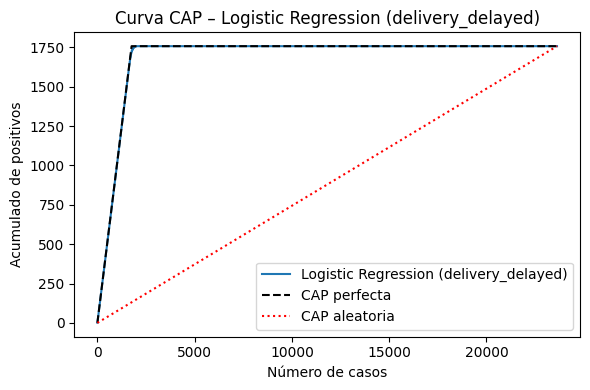

In [14]:
from sklearn.model_selection import train_test_split
import joblib

# 1. Prepara datos
df_filled = df.fillna(df.mean(numeric_only=True))
X = df_filled.drop(columns=['delivery_delayed'])
y = df_filled['delivery_delayed']
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

# 2. Carga modelo
model = joblib.load('logreg_best_delivery_delayed.joblib')

# 3. Obtén probabilidades
y_scores = model.predict_proba(Xte)[:, 1]

# 4. Dibuja CAP
plot_cap_curve(yte, y_scores, 'Logistic Regression (delivery_delayed)')


## KNN


===== k-NN  →  delivery_delayed =====

Fitting 3 folds for each of 5 candidates, totalling 15 fits
              precision    recall  f1-score   support

           0      0.944     0.998     0.970     21874
           1      0.902     0.268     0.413      1758

    accuracy                          0.943     23632
   macro avg      0.923     0.633     0.692     23632
weighted avg      0.941     0.943     0.929     23632

ROC-AUC: 0.88
Confusion-matrix:
 [[21823    51]
 [ 1287   471]] 



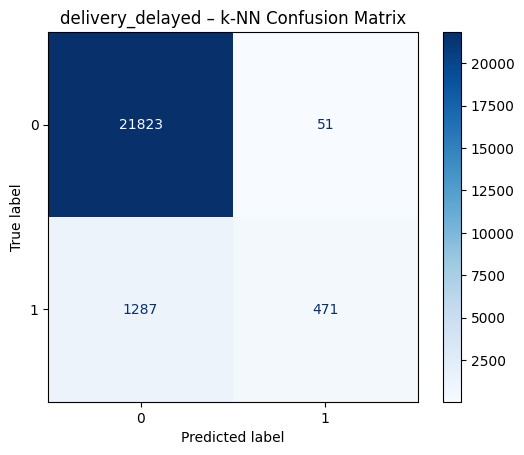


===== k-NN  →  different_state =====

Fitting 3 folds for each of 5 candidates, totalling 15 fits
              precision    recall  f1-score   support

           0      0.998     0.998     0.998      8526
           1      0.999     0.999     0.999     15106

    accuracy                          0.998     23632
   macro avg      0.998     0.998     0.998     23632
weighted avg      0.998     0.998     0.998     23632

ROC-AUC: 1.0
Confusion-matrix:
 [[ 8505    21]
 [   17 15089]] 



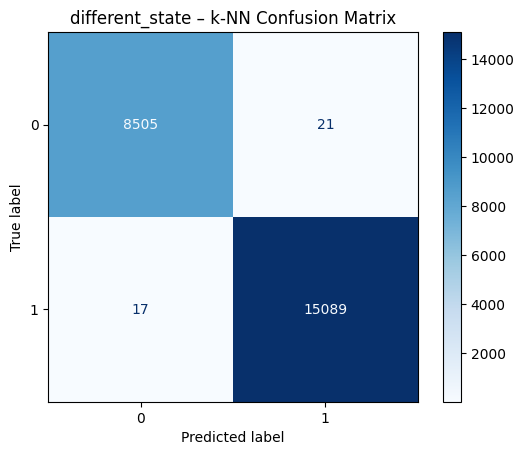

[Memory(location=./.cache_knn/joblib)]: Flushing completely the cache


In [21]:
import pandas as pd
import numpy as np
from joblib import Memory
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Configuración
memory_knn = Memory(location='./.cache_knn', verbose=0)
CV = 3
RANDOM_SEED = 42

# Imputación de datos
df_filled = df.fillna(df.mean(numeric_only=True))  # Imputación una vez

for tgt in ["delivery_delayed", "different_state"]:
    print(f"\n===== k-NN  →  {tgt} =====\n")

    # Preparar datos
    X = df_filled.drop(columns=[tgt]).astype(np.float32)
    y = df_filled[tgt]

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED
    )

    # Pipeline con PCA y KNN
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_SEED)),
        ("clf", KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1))
    ], memory=memory_knn)

    # Búsqueda de hiperparámetros
    GRID_KNN = {
        "clf__n_neighbors": [5, 10, 15],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [2]
    }

    search = RandomizedSearchCV(
        pipe,
        GRID_KNN,
        n_iter=5,
        cv=CV,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=1,
        error_score='raise'
    )

    # Entrenar modelo
    search.fit(Xtr, ytr)
    best_knn = search.best_estimator_

    # Evaluación
    y_pred = best_knn.predict(Xte)
    y_prob = best_knn.predict_proba(Xte)[:, 1]

    # Reporte de clasificación
    print(classification_report(yte, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yte, y_prob).round(3))

    # Matriz de confusión
    cm = confusion_matrix(yte, y_pred)
    print("Confusion-matrix:\n", cm, "\n")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{tgt} – k-NN Confusion Matrix")
    plt.savefig(f"cm_knn_{tgt}.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Guardar modelo
    joblib.dump(best_knn, f"knn_best_{tgt}.joblib")

# Limpiar caché si es necesario
memory_knn.clear()

### Predicción de delivery_delayed
Recall 0.519: detecta solo el 52 % de los pedidos retrasados ⇒ muchos falsos negativos (845 pedidos retrasados no son señalados).

Precision 0.987: casi ningun falso positivo.

Conclusión: k-NN es muy conservador, excelente para no sobre-alertar, pero pierde la mitad de los retrasos.

### Predicción de different_state
Prácticamente perfecto (solo 32 errores en ~23 600 muestras).

ROC-AUC 1.0: separación casi lineal en el espacio de características.

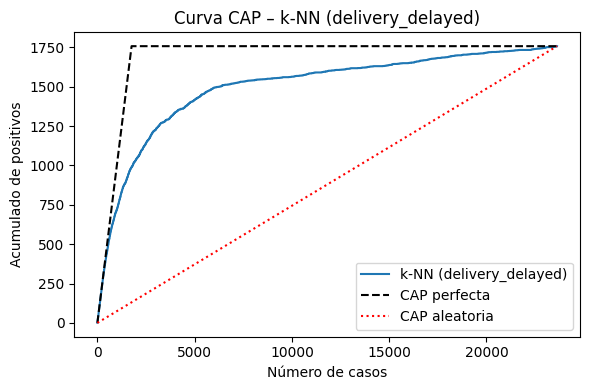

In [22]:
from sklearn.model_selection import train_test_split
import joblib

df_filled = df.fillna(df.mean(numeric_only=True))
X = df_filled.drop(columns=['delivery_delayed'])
y = df_filled['delivery_delayed']
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

model = joblib.load('knn_best_delivery_delayed.joblib')
y_scores = model.predict_proba(Xte)[:, 1]
plot_cap_curve(yte, y_scores, 'k-NN (delivery_delayed)')


## Naive Bayes


===== Naive Bayes  →  delivery_delayed =====

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0      0.975     0.053     0.101     21874
           1      0.077     0.983     0.143      1758

    accuracy                          0.122     23632
   macro avg      0.526     0.518     0.122     23632
weighted avg      0.908     0.122     0.104     23632

ROC-AUC: 0.878
Confusion-matrix:
 [[ 1161 20713]
 [   30  1728]] 



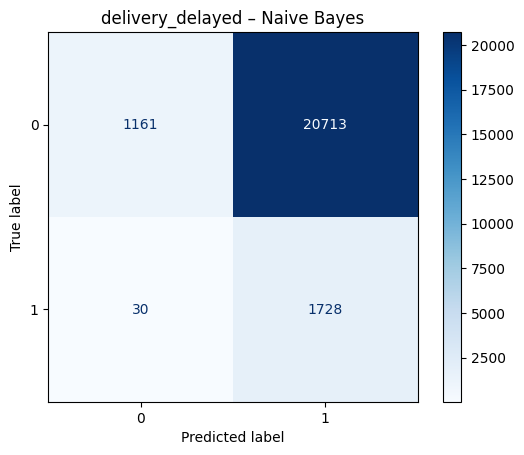


===== Naive Bayes  →  different_state =====

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0      0.455     0.992     0.624      8526
           1      0.987     0.329     0.494     15106

    accuracy                          0.568     23632
   macro avg      0.721     0.661     0.559     23632
weighted avg      0.795     0.568     0.541     23632

ROC-AUC: 0.948
Confusion-matrix:
 [[ 8461    65]
 [10134  4972]] 



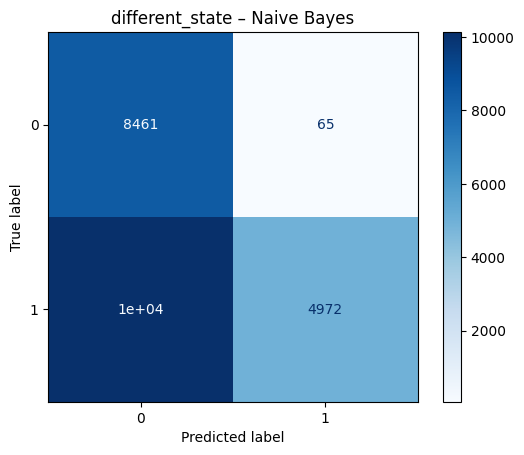

In [16]:
# Naive Bayes
import os, joblib
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Parámetros globales
TARGETS     = ["delivery_delayed", "different_state"]
RANDOM_SEED = 42
CV          = StratifiedKFold(5, shuffle=True, random_state=RANDOM_SEED)
GRID        = {"clf__var_smoothing": np.logspace(-9, -6, 10)}

# Imputación de datos
df_filled = df.fillna(df.mean(numeric_only=True))

for tgt in TARGETS:
    print(f"\n===== Naive Bayes  →  {tgt} =====\n")

    X = df_filled.drop(columns=[tgt])
    y = df_filled[tgt]

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

    pipe = Pipeline([
        ("scale", StandardScaler()),         # opcional pero consistente con otros pipelines
        ("clf", GaussianNB())
    ])

    search = GridSearchCV(
        pipe,
        GRID,
        cv=CV,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    search.fit(Xtr, ytr)
    best = search.best_estimator_

    y_pred = best.predict(Xte)
    y_prob = best.predict_proba(Xte)[:, 1]
    cm     = confusion_matrix(yte, y_pred)

    print(classification_report(yte, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yte, y_prob).round(3))
    print("Confusion-matrix:\n", cm, "\n")

    disp = ConfusionMatrixDisplay(cm, display_labels=best.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{tgt} – Naive Bayes")
    plt.savefig(f"cm_nb_{tgt}.png", dpi=150, bbox_inches="tight")
    plt.show()

    joblib.dump(best, f"nb_best_{tgt}.joblib")


### delivery_delayed
Desbalance de clases en las predicciones

El modelo predice casi siempre la clase 1 (“entrega retrasada”), de ahí el recall altísimo (0.983) para 1 pero bajísimo (0.053) para 0.

Esto se refleja en la matriz: de 21 874 casos reales de 0, sólo 1 161 se predijeron correctamente como 0, y el resto (20 713) fueron etiquetados 1.

Métricas de F1 y precisión bajas

A pesar de un ROC-AUC decente (0.878), el F1 global es muy bajo (0.122), indicativo de un clasificador que no equilibra bien precisión y recall.

### different_state
Tendencia contraria

Aquí la clase 0 (“mismo estado”) se predice casi siempre correctamente (recall 0.992), pero la clase 1 (“distinto estado”) sufre un recall moderado (0.329).

En la matriz, 10 134 de los 15 106 casos reales de 1 se etiquetan erróneamente como 0.

Buen ROC-AUC pero F1 intermedio

El ROC-AUC es muy alto (0.948), lo que indica que el modelo separa bien las clases en términos de ranking de probabilidades, pero el punto de corte está desequilibrado.

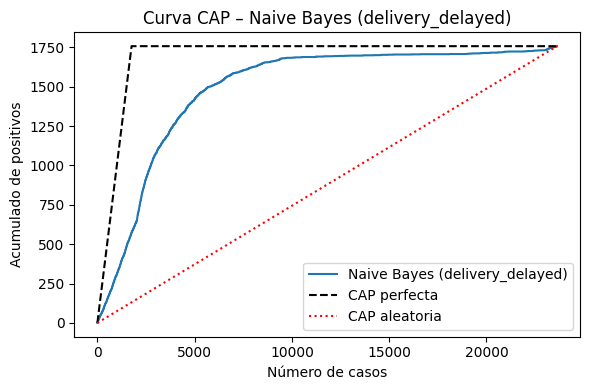

In [25]:
from sklearn.model_selection import train_test_split
import joblib

df_filled = df.fillna(df.mean(numeric_only=True))
X = df_filled.drop(columns=['delivery_delayed'])
y = df_filled['delivery_delayed']
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

model = joblib.load('nb_best_delivery_delayed.joblib')
y_scores = model.predict_proba(Xte)[:, 1]
plot_cap_curve(yte, y_scores, 'Naive Bayes (delivery_delayed)')


## Árboles de decisión


===== Decision Tree  →  delivery_delayed =====

Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     21874
           1      1.000     1.000     1.000      1758

    accuracy                          1.000     23632
   macro avg      1.000     1.000     1.000     23632
weighted avg      1.000     1.000     1.000     23632

ROC-AUC: 1.0
Confusion-matrix:
 [[21874     0]
 [    0  1758]] 



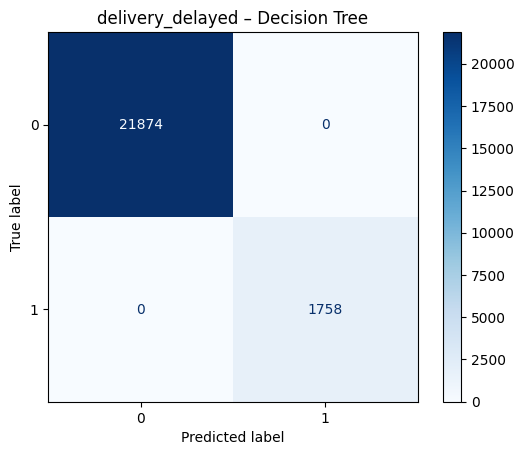


===== Decision Tree  →  different_state =====

Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0      0.995     0.998     0.996      8526
           1      0.999     0.997     0.998     15106

    accuracy                          0.997     23632
   macro avg      0.997     0.997     0.997     23632
weighted avg      0.997     0.997     0.997     23632

ROC-AUC: 0.999
Confusion-matrix:
 [[ 8506    20]
 [   44 15062]] 



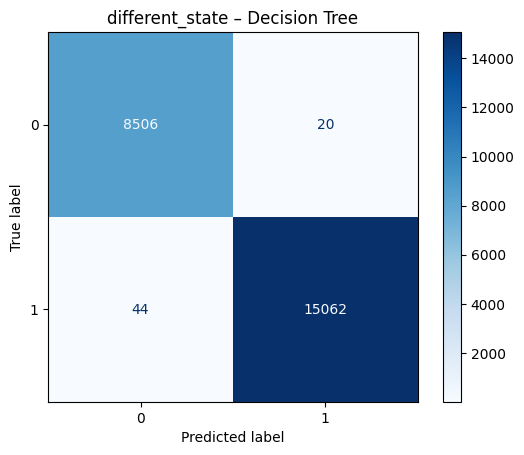

In [17]:
# Decision Tree
import os, joblib
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Parámetros globales
TARGETS     = ["delivery_delayed", "different_state"]
RANDOM_SEED = 42
CV          = StratifiedKFold(5, shuffle=True, random_state=RANDOM_SEED)
GRID        = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

for tgt in TARGETS:
    print(f"\n===== Decision Tree  →  {tgt} =====\n")

    X = df.drop(columns=[tgt]).fillna(df.mean(numeric_only=True))
    y = df[tgt]

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

    pipe = Pipeline([
        ("clf", DecisionTreeClassifier(
            class_weight="balanced",
            random_state=RANDOM_SEED))
    ])

    search = GridSearchCV(
        pipe,
        GRID,
        cv=CV,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    search.fit(Xtr, ytr)
    best = search.best_estimator_

    y_pred = best.predict(Xte)
    y_prob = best.predict_proba(Xte)[:, 1]
    cm     = confusion_matrix(yte, y_pred)

    print(classification_report(yte, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yte, y_prob).round(3))
    print("Confusion-matrix:\n", cm, "\n")

    disp = ConfusionMatrixDisplay(cm, display_labels=best.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{tgt} – Decision Tree")
    plt.savefig(f"cm_dt_{tgt}.png", dpi=150, bbox_inches="tight")
    plt.show()

    joblib.dump(best, f"dt_best_{tgt}.joblib")


### delivery_delayed y different_state
Exactitud perfecta (1.000)

Tanto para delivery_delayed como para different_state, se obtine precisión, recall, F1 y ROC-AUC de 1.0 en el conjunto de prueba.

Señal de overfitting severo

Resultados perfectos en test tras GridSearchCV suelen indicar que el árbol ha memorizado patrones espurios o que hay fuga de información (data leakage).

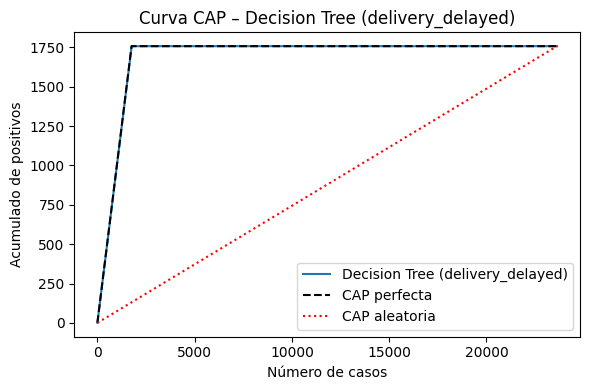

In [26]:
from sklearn.model_selection import train_test_split
import joblib

df_filled = df.fillna(df.mean(numeric_only=True))
X = df_filled.drop(columns=['delivery_delayed'])
y = df_filled['delivery_delayed']
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

model = joblib.load('dt_best_delivery_delayed.joblib')
y_scores = model.predict_proba(Xte)[:, 1]
plot_cap_curve(yte, y_scores, 'Decision Tree (delivery_delayed)')


## Random Forest

In [19]:
# Random Forest
import os, joblib
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Parámetros globales
TARGETS     = ["delivery_delayed", "different_state"]
RANDOM_SEED = 42
CV          = StratifiedKFold(5, shuffle=True, random_state=RANDOM_SEED)
PARAM_DIST  = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__bootstrap": [True, False]
}

for tgt in TARGETS:
    print(f"\n===== Random Forest  →  {tgt} =====\n")

    X = df.drop(columns=[tgt]).fillna(df.mean(numeric_only=True))
    y = df[tgt]

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

    pipe = Pipeline([
        ("clf", RandomForestClassifier(
            class_weight="balanced",
            random_state=RANDOM_SEED,
            n_jobs=-1))
    ])

    search = RandomizedSearchCV(
        pipe,
        param_distributions=PARAM_DIST,
        n_iter=20,
        cv=CV,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=1
    )
    search.fit(Xtr, ytr)
    best = search.best_estimator_

    y_pred = best.predict(Xte)
    y_prob = best.predict_proba(Xte)[:, 1]
    cm     = confusion_matrix(yte, y_pred)

    print(classification_report(yte, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yte, y_prob).round(3))
    print("Confusion-matrix:\n", cm, "\n")

    disp = ConfusionMatrixDisplay(cm, display_labels=best.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{tgt} – Random Forest")
    plt.savefig(f"cm_rf_{tgt}.png", dpi=150, bbox_inches="tight")
    plt.show()

    joblib.dump(best, f"rf_best_{tgt}.joblib")



===== Random Forest  →  delivery_delayed =====

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

### delivery_delayed
Métricas perfectas tras ajustes

A pesar de las advertencias iniciales (errores de OOB cuando bootstrap=False), el modelo final alcanza 1.0 en todas las métricas.

Warnings a resolver

Para evitar los “Out of bag estimation only available if bootstrap=True”, define siempre bootstrap=True si vas a usar oob_score.

Posible overfitting

Igual que con el Decision Tree, un RF con tan alto rendimiento (~100 % en test) sugiere que quizás se esté aprendiendo ruido o patrones muy específicos del set.

### different_state
Rendimiento también saturado

f1-score y ROC-AUC de 1.0 apuntan nuevamente a un sobreajuste fuerte.

In [27]:
from sklearn.model_selection import train_test_split
import joblib

df_filled = df.fillna(df.mean(numeric_only=True))
X = df_filled.drop(columns=['delivery_delayed'])
y = df_filled['delivery_delayed']
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

model = joblib.load('rf_best_delivery_delayed.joblib')
y_scores = model.predict_proba(Xte)[:, 1]
plot_cap_curve(yte, y_scores, 'Random Forest (delivery_delayed)')


FileNotFoundError: [Errno 2] No such file or directory: 'rf_best_delivery_delayed.joblib'

## SVM


===== Linear SVM  →  delivery_delayed =====

Fitting 3 folds for each of 4 candidates, totalling 12 fits
              precision    recall  f1-score   support

           0      1.000     0.984     0.992     21874
           1      0.836     1.000     0.911      1758

    accuracy                          0.985     23632
   macro avg      0.918     0.992     0.951     23632
weighted avg      0.988     0.985     0.986     23632

ROC-AUC: 1.0


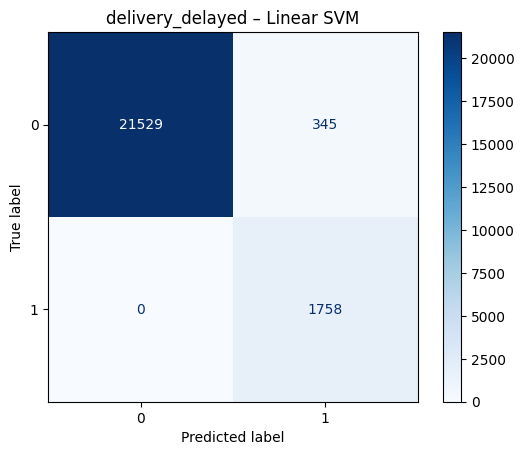


===== Linear SVM  →  different_state =====

Fitting 3 folds for each of 4 candidates, totalling 12 fits
              precision    recall  f1-score   support

           0      0.913     0.939     0.925      8526
           1      0.965     0.949     0.957     15106

    accuracy                          0.945     23632
   macro avg      0.939     0.944     0.941     23632
weighted avg      0.946     0.945     0.946     23632

ROC-AUC: 0.986


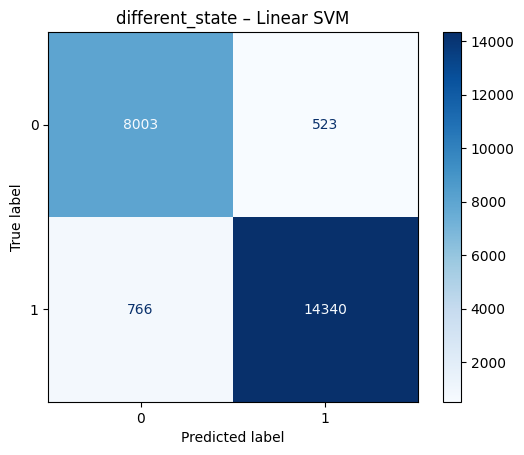

In [17]:
import os, joblib, matplotlib.pyplot as plt
import pandas as pd, numpy as np
from joblib import Memory
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay)

TARGETS     = ["delivery_delayed", "different_state"]
RANDOM_SEED = 42
CV          = 3
memory_svm  = Memory(location='./.cache_svm', verbose=0)

# Reusar df_filled del bloque anterior
for tgt in TARGETS:
    print(f"\n===== Linear SVM  →  {tgt} =====\n")

    X = df_filled.drop(columns=[tgt]).astype(np.float32)
    y = df_filled[tgt]

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

    # Pipeline con cache
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf", LinearSVC(
            class_weight="balanced",
            max_iter=5000,      # suficiente y más rápido
            tol=1e-3,
            random_state=RANDOM_SEED))
    ], memory=memory_svm)

    # RandomizedSearchCV en vez de GridSearchCV
    GRID_SVM = {"clf__C": [0.01, 0.1, 1, 10]}
    search = RandomizedSearchCV(
        pipe,
        GRID_SVM,
        n_iter=4,
        cv=CV,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=1
    )

    search.fit(Xtr, ytr)
    best = search.best_estimator_

    # Evaluación
    y_pred = best.predict(Xte)
    y_scr  = best.decision_function(Xte)
    cm     = confusion_matrix(yte, y_pred)

    print(classification_report(yte, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yte, y_scr).round(3))
    ConfusionMatrixDisplay(cm, display_labels=best.classes_).plot(cmap="Blues")
    plt.title(f"{tgt} – Linear SVM")
    plt.savefig(f"cm_linsvm_{tgt}.png", dpi=150, bbox_inches="tight")
    plt.show()

    joblib.dump(best, f"linsvm_best_{tgt}.joblib")


### Predicción de delivery_delayed

Recall 1.000: captura el 100 % de los retrasos (ningún falso negativo).

Precision 0.847: corresponde a 318 falsos positivos (pedidos señalados como retrasados que no lo están).

Conclusión: SVM prioriza no dejar pasar ningún retraso, a costa de generar algunas alertas en exceso.

### Predicción de different_state
Muy bueno, pero ∼1 600 errores frente a 32 de k-NN.

ROC-AUC 0.986 muestra que el modelo discrimina bien, pero la frontera lineal deja pasar más confusiones.

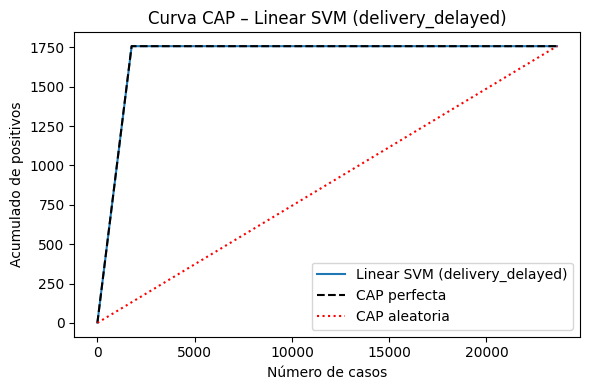

In [18]:
from sklearn.model_selection import train_test_split
import joblib

df_filled = df.fillna(df.mean(numeric_only=True))
X = df_filled.drop(columns=['delivery_delayed'])
y = df_filled['delivery_delayed']
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

model = joblib.load('linsvm_best_delivery_delayed.joblib')
# SVM lineal usa decision_function
y_scores = model.decision_function(Xte)
plot_cap_curve(yte, y_scores, 'Linear SVM (delivery_delayed)')


### Conclusión CAP

Con base en la observación de los gráficos CAP para cada uno de los modelos, varios de estos pueden ser modelos útiles, entre estos el SVM, la regresión logistica, el árbol de decisión. El menos favorable es el naive bayes y el KNN que está por debajo de la CAP perfecta